In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,Flatten,Dense,Dropout

In [3]:
import os
import random

source = r"/content/drive/MyDrive/cells_pics "
destination = r"/content/drive/MyDrive/cells_pics_split"

os.makedirs(os.path.join(destination, "train"), exist_ok=True)
os.makedirs(os.path.join(destination, "valid"), exist_ok=True)
os.makedirs(os.path.join(destination, "test"), exist_ok=True)

for category in os.listdir(source):
    category_path = os.path.join(source, category)

    if not os.path.isdir(category_path):
        continue

    os.makedirs(os.path.join(destination, "train", category), exist_ok=True)
    os.makedirs(os.path.join(destination, "valid", category), exist_ok=True)
    os.makedirs(os.path.join(destination, "test", category), exist_ok=True)

    files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    random.shuffle(files)

    train_size = int(0.7 * len(files))
    valid_size = int(0.2 * len(files))

    train_files = files[:train_size]
    valid_files = files[train_size:train_size + valid_size]
    test_files = files[train_size + valid_size:]


    for file in train_files:
        old_path = os.path.join(category_path, file)
        new_path = os.path.join(destination, "train", category, file)
        os.rename(old_path, new_path)

    for file in valid_files:
        old_path = os.path.join(category_path, file)
        new_path = os.path.join(destination, "valid", category, file)
        os.rename(old_path, new_path)

    for file in test_files:
        old_path = os.path.join(category_path, file)
        new_path = os.path.join(destination, "test", category, file)
        os.rename(old_path, new_path)

print("Files have been successfully moved!")


Files have been successfully moved!


In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    rescale=1./255,
    brightness_range=(0.8, 1.2),
    channel_shift_range=20.0,
    zca_whitening=False,
    zca_epsilon=1e-06
)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
train_dir="/content/drive/MyDrive/cells_pics_split/train"
test_dir="/content/drive/MyDrive/cells_pics_split/test"
valid_dir="/content/drive/MyDrive/cells_pics_split/valid"

In [6]:
train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
test= test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
valid= valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 3500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [7]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),

                      )


for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-24:]:
    layer.trainable = True


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [8]:
from tensorflow.keras.models import Model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x = Flatten()(x)
x = Dense(224, activation='relu')(x)

x = Dense(128, activation='relu')(x)

x = Dense(64, activation='relu')(x)

x = Dense(5, activation='softmax')(x)

model = Model(inputs, x)


learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 224)                 │      22,479,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          28,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,104,165 (175.87 MB)

 Trainable params: 31,455,973 (120.00 MB)

 Non-trainable params: 14,648,192 (55.88 MB)

In [ ]:
history = model.fit(
        train,
        epochs=15,

        validation_data=valid)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 2319s 21s/step - accuracy: 0.4447 - loss: 1.3456 - val_accuracy: 0.2000 - val_loss: 1.8328
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 667ms/step - accuracy: 0.7388 - loss: 0.7032 - val_accuracy: 0.2870 - val_loss: 3.0916
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 661ms/step - accuracy: 0.7860 - loss: 0.5534 - val_accuracy: 0.4700 - val_loss: 1.6678
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 662ms/step - accuracy: 0.8113 - loss: 0.5199 - val_accuracy: 0.8570 - val_loss: 0.3969
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 660ms/step - accuracy: 0.8071 - loss: 0.5076 - val_accuracy: 0.8470 - val_loss: 0.4273
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 664ms/step - accuracy: 0.8298 - loss: 0.4374 - val_accuracy: 0.9080 - val_loss: 0.2662
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 73s 663ms/step - accuracy: 0.8453 - loss: 0.4332 - val_accuracy: 0.9050 - val_loss: 0.2493
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 661ms/step - accuracy: 0.8545 - loss: 0

In [15]:
model.save("Blood_cell_best.h5")


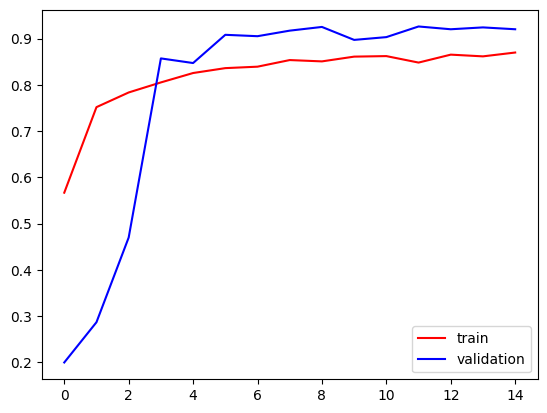

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

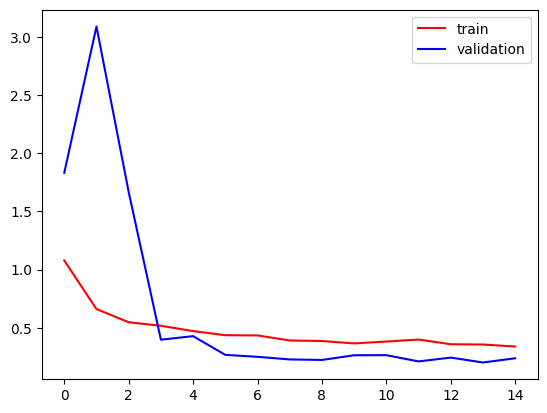

In [17]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [6]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model= load_model("/content/drive/MyDrive/blood_cell_best.h5")


img_path = "/content/drive/MyDrive/cells_pics_split/test/seg_neutrophil/NGS_2554.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)

print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: 4


In [24]:
model.save("/content/drive/MyDrive/blood_cell_best.h5")
